## Data Science Final Project Report: Predicting Player Playtime in a Minecraft Research Server


**Group Members**:


Han Nguyen     

Vincent Nguyen

Sanuli Weihena Gamage

Huixin Zhang



# Introduction

Understanding player behavior is essential for optimizing resources and improving user experience in online gaming environments. In this project, we analyze data collected from a Minecraft research server operated by a UBC Computer Science research group led by Frank Wood. The server records player actions, providing valuable insights into gaming patterns. However, managing such a project requires careful resource allocation, ensuring sufficient server capacity and targeted recruitment strategies. To support these efforts, we investigate key player characteristics that may influence their engagement.

We start with the broad question of interest:

**We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.**

Then, we come to a narrower question, focusing on the predictiveness of some features of players to the amount of data they contributed, as follows:

**Can the experience and age of players (predictors) accurately predict their total play time (response variable) using multivariate K-Nearest Neighbors (KNN) and multivariate linear regression?** 

To address this, we focus on the `players.csv` dataset, which contains relevant features such as player age, experience level, and total playtime. The `sessions.csv` dataset, which logs individual gameplay sessions, is not directly useful for this analysis since we are interested in aggregated player behavior rather than session-specific details. By applying predictive modeling techniques, we aim to uncover meaningful relationships between player attributes and their total playtime, providing actionable insights for the research team.

### Data summary

There are 2 datasets available: `players.csv` and `sessions.csv`, but we will only look at the relevant one, which is `players.csv`. 


players.csv : A list of all unique players, including data about each player. From this dataset with ~200 observations, there are 7 variables we can look at: 

`hashedEmail` `(chr)`: Unique identifier for players (hashed for privacy).

`experience` `(chr)` = How experienced the player is.

`subscribe` `(lgl)` = Whether this player subscribed to the newsletter.

`played_hours`  `(dbl)` = Total time spent playing in hours.

`name` `(chr)` = Name of the player.

`gender` `(chr)` = Gender of the player.

`age` `(dbl)` = Age of the player. 

To take a better look, we will first load the dataset and assign it to an object, `players`.

# Methods & Results:

### 1. Data analysis

In [1]:
# Loads the library
library(tidyverse)
library(repr)
library(tidymodels)
library(readr)
library(ggplot2)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In my group, we want to test: *Can the experience and age of players (predictors) accurately predict their total play time (response variable) using multivariate K-Nearest Neighbors (KNN) and multivariate linear regression?*

The `player_csv` is suitable for observing private information about players.

In [2]:
# Loads the dataset
url <- "https://raw.githubusercontent.com/Han27-io/ds-project/refs/heads/main/players%20(1).csv"
players <- read_csv(url)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


From the dataset above, `subscribe`, `hashedEmail`, `name`, and `gender` can be disselected since they won't contribute to the further analysis. Additionally, there are 2 missing values of variable `Age`, which are insignificant compared to 196 observations in total; we delete them to make wrangling and visualizing steps easier.

In [3]:
# Wrangles the data
players_tidy <- players |>
                select(experience, played_hours, Age) |>
                filter(Age != "NA") |>
                mutate(experience = factor(experience))
players_tidy

experience,played_hours,Age
<fct>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
⋮,⋮,⋮
Veteran,0.3,22
Amateur,0.0,17
Amateur,2.3,17


In order to hypothesize the predictiveness of age and experience level about the total playtime, we visualize the graph of the predictors and the response variable.

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 12
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

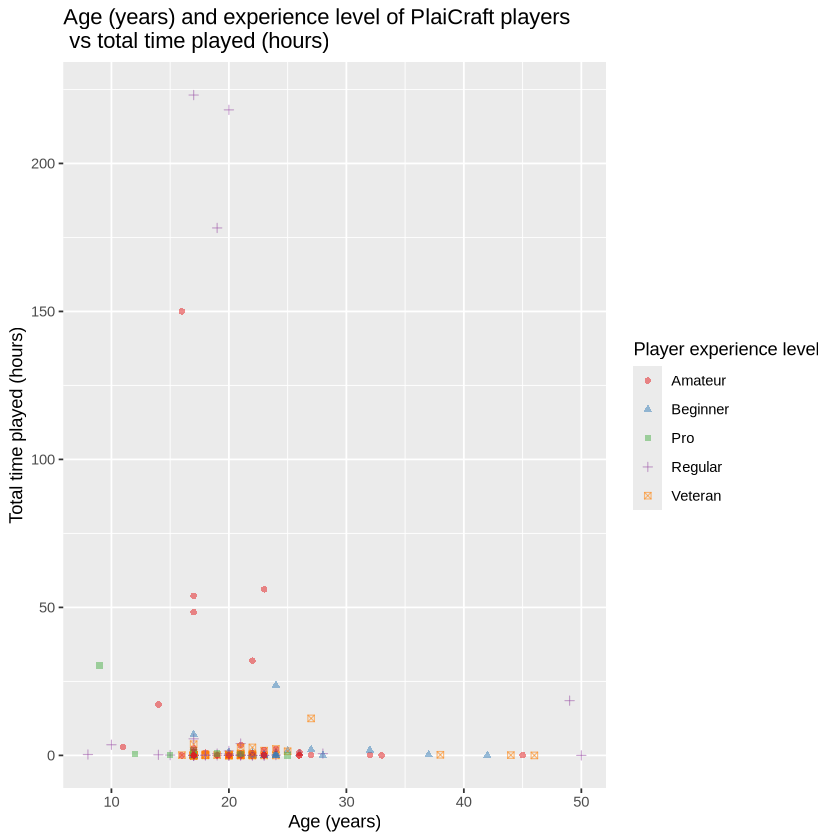

In [4]:
options(repr.height.plot = 8, repr.width.plot = 15)
# Visualizes the scatter plot showing the relationship between predictors and response variable
players_scatter_plot <- players_tidy |> 
ggplot(aes(x = Age, y = played_hours, color = experience, shape = experience)) + 
geom_point(alpha = 0.5) + 
labs(title = "Age (years) and experience level of PlaiCraft players \n vs total time played (hours)", x = "Age (years)", y = "Total time played (hours)", color = "Player experience level", shape = "Player experience level") + 
scale_color_brewer(palette = "Set1")
theme(text = element_text(size = 12))

players_scatter_plot

Due to outliers at the extremities of the x- and y-axis, it’s difficult to take value insights from the graph. Instead, we can split the graph into two bar graphs to better display the relationship between each predictor and response variable.

In [5]:
# Creates the table of mean playtime and total oservation of each category of experience
played_hours_experience <- players_tidy |> 
                                group_by(experience) |> 
                                summarize(avg_hours = mean(played_hours), count = n())
played_hours_experience

experience,avg_hours,count
<fct>,<dbl>,<int>
Amateur,6.0174603,63
Beginner,1.2485714,35
Pro,2.7846154,13
Regular,18.7257143,35
Veteran,0.6479167,48


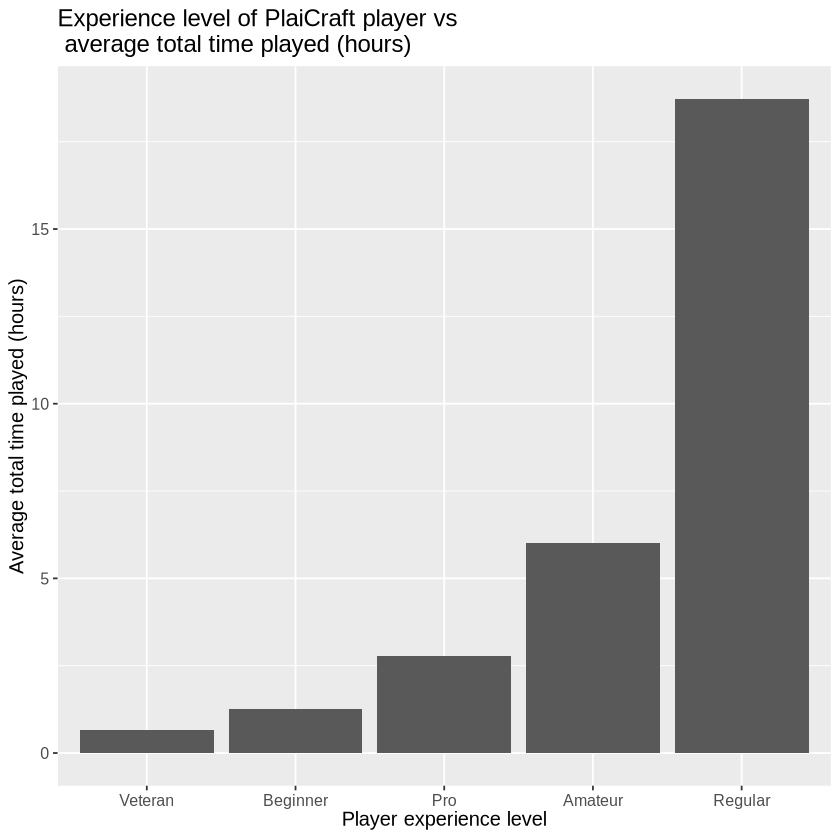

In [6]:
# Visualizes the bar graph between the avarage played time and categories of experience
experience_aver_bar_plot <- played_hours_experience |> 
ggplot(aes(x = fct_reorder(experience, avg_hours, .desc = FALSE), y = avg_hours)) + 
geom_bar(stat = "identity") + 
labs(x = "Player experience level", 
     y = "Average total time played (hours)",
     title = "Experience level of PlaiCraft player vs \n average total time played (hours)") + 
theme(text = element_text(size = 12))

experience_aver_bar_plot

- Regular players have the highest playtime, while Veterans surprisingly have the lowest.
- Beginners also play less, but that makes sense since they are new.
- Amateurs play more than Pros, suggesting skill level isn’t directly tied to playtime.
- This non-linear relationship suggests that experience level may be a more complex predictor than expected.

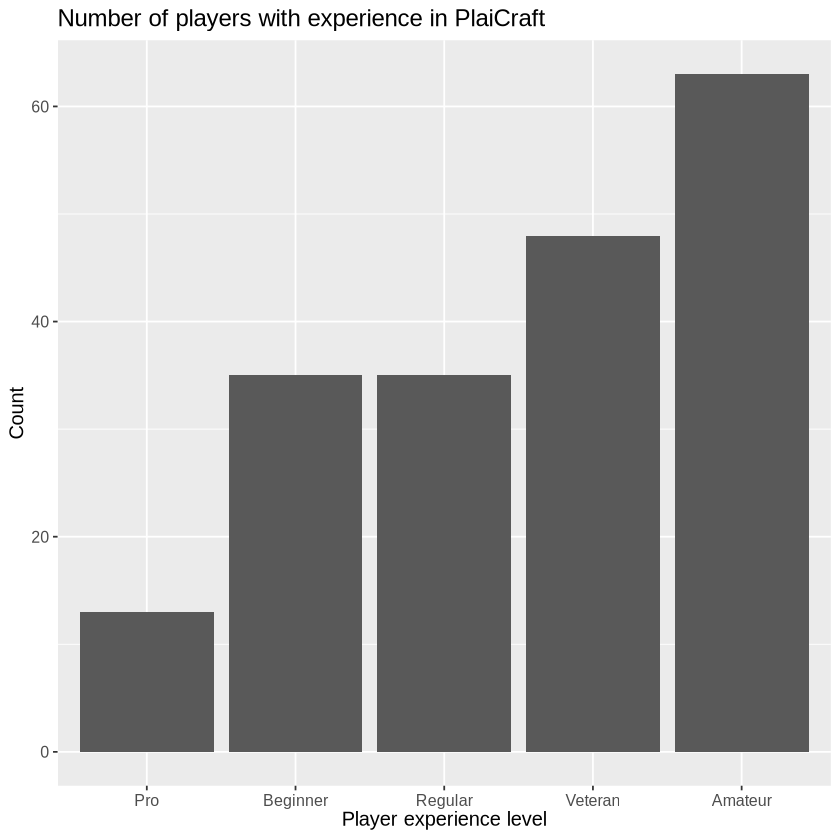

In [7]:
# Visualizes the bar graph of the total number of observations of each category of experience
experience_count_bar_plot <- played_hours_experience |> 
ggplot(aes(x = fct_reorder(experience, count, .desc = FALSE), y = count)) + 
geom_bar(stat = "identity") + 
labs(x = "Player experience level", 
     y = "Count",
     title = "Number of players with experience in PlaiCraft") + 
theme(text = element_text(size = 12))

experience_count_bar_plot

- The majority of players are Amateurs and Veterans.
- Beginners and Regulars have even distribution.
- Pros is the least common.
- There is a clear imbalance in experience distribution, which might influence predictions.

In [8]:
# Creates the table of the mean playtime and total number of observations of each age
played_hours_age <- players_tidy |> 
                        group_by(Age) |> 
                        summarize(avg_hours = mean(played_hours),
                                 count = n())
played_hours_age

Age,avg_hours,count
<dbl>,<dbl>,<int>
8,0.3,1
9,30.3,1
10,3.6,1
⋮,⋮,⋮
46,0.0,1
49,18.5,1
50,0.0,1


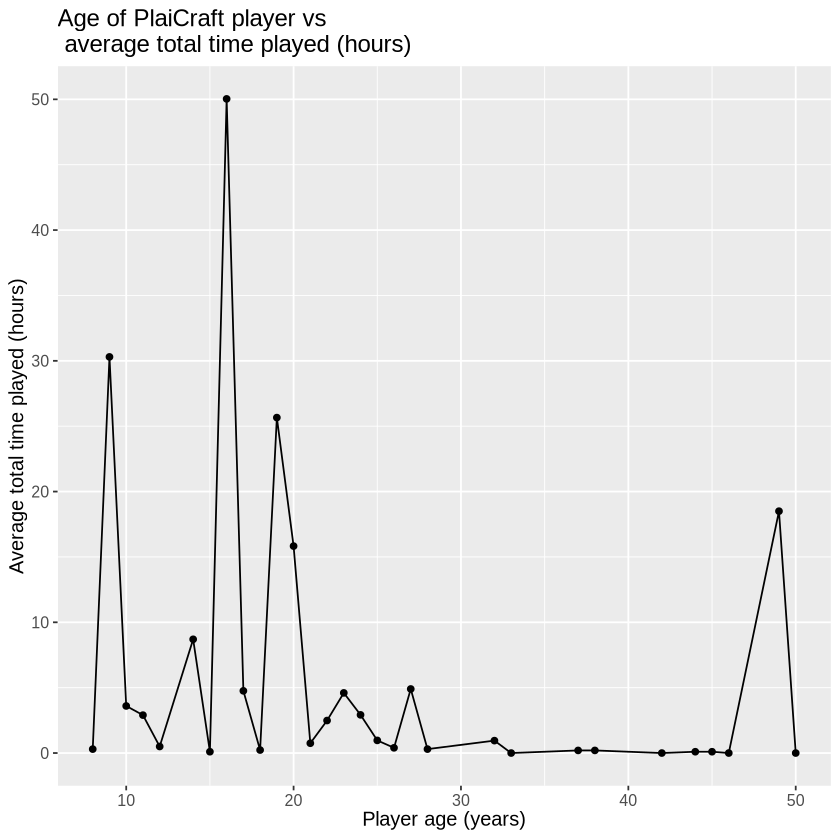

In [9]:
# Visualizes the line graph between the avarage played time and ages
age_aver_bar_plot <- played_hours_age |> 
ggplot(aes(x = Age, y = avg_hours)) + 
geom_line() + 
geom_point() +
labs(x = "Player age (years)", 
     y = "Average total time played (hours)", 
     title = "Age of PlaiCraft player vs \n average total time played (hours)") + 
theme(text = element_text(size = 12))

age_aver_bar_plot

- There is no clear linear trend between age and playtime.
- Some younger players (below 15) and some older players (above 45) have high playtime, but most of the playtime is scattered and inconsistent.
- Peak playtime happens at certain ages (e.g., 8, 16, 49) but not consistently across all ages.
- This suggests that age alone is not a strong predictor of playtime.

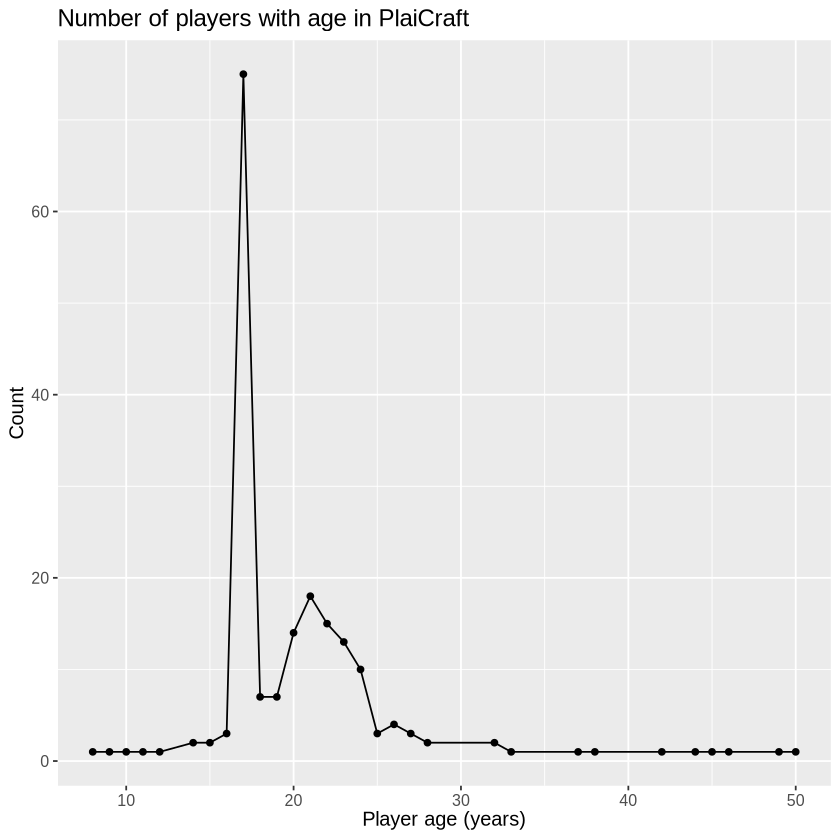

In [10]:
# Visualizes the line graph of the number of observation for each age
age_count_line_plot <- played_hours_age |> 
ggplot(aes(x = Age, y = count)) + 
geom_line() + 
geom_point() +
labs(x = "Player age (years)", 
     y = "Count", 
     title = "Number of players with age in PlaiCraft") + 
theme(text = element_text(size = 12))

age_count_line_plot

- The majority of players are clustered between ages 17–22, with a massive spike at age 17.
- There are fewer younger (below 15) and older (above 30) players.
- The distribution is highly imbalanced, which may affect predictive accuracy.

In [22]:
played_hours_stat <- players_tidy |>
                     summarize(mean = mean(played_hours),
                               range = max(played_hours) - min(played_hours))
played_hours_stat

mean,range
<dbl>,<dbl>
5.904639,223.1


After the analysis, we come to the hypothesis:

**Experience level and age together can moderately predict total playtime, but their relationship with playtime is non-linear, meaning K-Nearest Neighbors (KNN) will provide better predictions than linear regression.**

Additionally, we need to find out the range and the mean of total playtime to evaluate the accuracy of the model performance.

### 2. Pre-process data

Since both models we're using to predict directly applying the Euclid distance formula, we need to convert all the predictors into numeric values, specifically the `experience` variable.

Additionally, we will split the dataset into training and testing sets (75% training and 25% testing).

In [11]:
# Converts experience values into numbers
players_pre <- players_tidy |>
               mutate(experience = as.numeric(experience))

players_pre

experience,played_hours,Age
<dbl>,<dbl>,<dbl>
3,30.3,9
5,3.8,17
5,0.0,17
⋮,⋮,⋮
5,0.3,22
1,0.0,17
1,2.3,17


In [12]:
set.seed(7)
# Spits the dataset
players_split <- initial_split(players_pre, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

### 3. Performing K-Nearest Neighbor Model

First, we gonna use KNN model to predict the `played_hours` variable with 2 predictors `Age` and `experience`. We will follow the following steps:

1. Training the model
2. Tuning the model
3. Choosing the best $K$ based on RMSE value
4. Applying the model for the testing set and collect the RMSPE

In [13]:
set.seed(7)
# Trains the model 
players_recipe <- recipe(played_hours ~ experience + Age, data = players_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_wkflw <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(players_spec)

players_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [14]:
set.seed(7)
# Tunes the models
gridvals <- tibble(neighbors = seq(from = 1, to = 114, by = 1))

players_results <- players_wkflw |>
                   tune_grid(resamples = players_vfold, grid = gridvals) |>
                   collect_metrics() |>
                   filter(.metric == "rmse")

players_results

→ A | warning: 114 samples were requested but there were 114 rows in the data. 109 will be used.

There were issues with some computations   A: x1

→ B | warning: 114 samples were requested but there were 116 rows in the data. 111 will be used.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

→ C | warning: 114 samples were requested but there were 117 rows in the data. 112 will be used.

There were issues with some computations   A: x1   B: x1
There were issues with some computations   A: x1   B: x2   C: x2

There were issues with some computations   A: x1   B: x2   C: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,30.57075,5,11.969150,Preprocessor1_Model001
2,rmse,standard,30.87461,5,9.370499,Preprocessor1_Model002
3,rmse,standard,30.74266,5,7.554933,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
112,rmse,standard,24.22644,5,9.081751,Preprocessor1_Model112
113,rmse,standard,24.20629,5,9.093821,Preprocessor1_Model113
114,rmse,standard,24.22313,5,9.078988,Preprocessor1_Model114


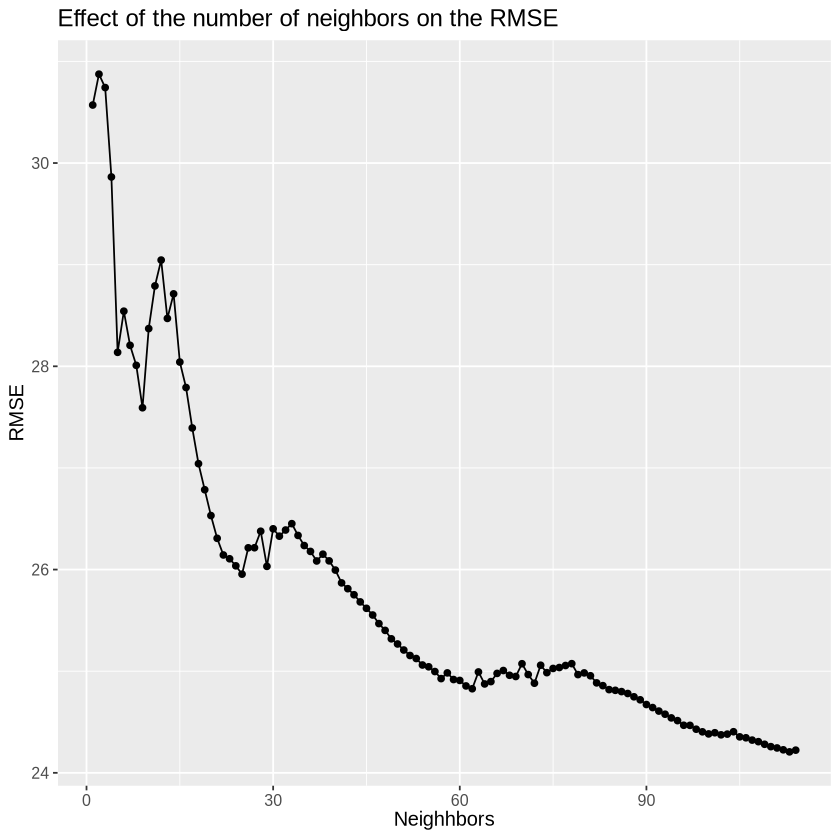

In [15]:
# Visualizes the RMSE value for each K
k_plot <- ggplot(players_results, aes(x = neighbors, y = mean)) +
          geom_point() +
          geom_line() +
          labs(x = "Neighhbors",
               y = "RMSE",
               title = "Effect of the number of neighbors on the RMSE") +
          theme(text = element_text(size = 12))

k_plot

In [16]:
# Choose the K value with smallest RMSE value
players_min <- players_results |>
               filter(mean == min(mean))

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
113,rmse,standard,24.20629,5,9.093821,Preprocessor1_Model113


In [17]:
set.seed(7)
# Performs the model with approriate K value
kmin <- players_min |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_training)

players_summary <- players_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.72287


The KNN model shows slight underfitting, with an RMSE of 24.21 (about 10.86% of the response range) and an RMSPE of 21.72, indicating moderate prediction errors. The high K value (113/150) ensures stability but smooths out finer variations in playtime, leading to a trade-off between bias and variance. While the model captures general trends, it lacks precision for extreme values, making it moderately effective for predicting total playtime.

### 4. Performing Linear Regression Model

Now, we're going to use Linear Regression model to predict the `played_hours` variable with 2 predictors `Age` and `experience`. We will follow the following steps:

1. Training the model
2. Applying the model for the testing set and collect the RMSPE

In [23]:
set.seed(7)
# Trains the model
lm_spec <- linear_reg() |>
           set_engine("lm") |>
           set_mode("regression")

lm_recipe <- recipe(played_hours ~ experience + Age, data = players_training)

lm_fit <- workflow() |>
          add_recipe(lm_recipe) |>
          add_model(lm_spec) |>
          fit(data = players_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   experience          Age  
     7.6761       1.2740      -0.2396  


From the training model, we come to the equation of the line of best fit is:
`played_hours`$ = 7.6161 + 1.2749 * $ `experience` $ - 0.2396 * $`Age`

In [26]:
set.seed(7)

# Fits the models and collect the RMSPE value
lm_test_results <- lm_fit |>
                   predict(players_testing) |>
                   bind_cols(players_testing) |>
                   metrics(truth = played_hours, estimate = .pred) |>
                   filter(.metric == "rmse")

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.14188


The linear regression model has an RMSPE of 22.14, indicating a moderate level of prediction error. Given the potential non-linearity in the relationship between age, experience, and playtime, the model may struggle to fully capture complex patterns, leading to limited predictive accuracy. This suggests that while age and experience contribute to playtime, their effect may not follow a strictly linear trend.